# Joint Multi Wind Farm Optimization

TopFarm is capable of doing a joint optimization over multiple wind farms at once. This way we can define multiple boundaries assigned to a cluster of turbines, seperating them into blocks.

In [2]:
# Install TopFarm if needed
import importlib
if not importlib.util.find_spec("topfarm"):
    !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/TopFarm2.git

Import required modules

In [3]:
import numpy as np
import topfarm
import matplotlib.pyplot as plt
from topfarm import TopFarmProblem
from topfarm.constraint_components.boundary import (
    MultiWFBoundaryConstraint,
    BoundaryType,
)
from topfarm.constraint_components.constraint_aggregation import (
    DistanceConstraintAggregation,
)
from topfarm.constraint_components.spacing import SpacingConstraint
from topfarm.cost_models.py_wake_wrapper import (
    PyWakeAEPCostModelComponent,
)
from topfarm.easy_drivers import EasyScipyOptimizeDriver, EasySGDDriver
from topfarm.plotting import XYPlotComp
from py_wake.literature.gaussian_models import Bastankhah_PorteAgel_2014
from py_wake.utils.gradients import autograd
from py_wake.validation.lillgrund import LillgrundSite
from py_wake.wind_turbines.generic_wind_turbines import GenericWindTurbine
from topfarm.cost_models.cost_model_wrappers import AEPCostModelComponent
from topfarm.cost_models.cost_model_wrappers import CostModelComponent
from py_wake.site import UniformWeibullSite


PyWake model setup

In [13]:
wind_turbines = GenericWindTurbine("GenWT", 100.6, 2000, 150)

#site = LillgrundSite()

freqs_summer = np.load('freqs_summer.npy')
ks_summer = np.load('ks_summer.npy')
As_summer = np.load('As_summer.npy')
freqs_winter = np.load('freqs_winter.npy')
ks_winter = np.load('ks_winter.npy')  
As_winter = np.load('As_winter.npy')
freqs_year = np.load('freqs_year.npy')
ks_year = np.load('ks_year.npy')
As_year = np.load('As_year.npy')
site = UniformWeibullSite(p_wd=freqs_year,
                          a=As_year,
                          k=ks_year,
                          ti=0.1)  # turbulence intensity, optional

wf_model = Bastankhah_PorteAgel_2014(
    site,
    wind_turbines,
    k=0.0324555,  # default value from BastankhahGaussianDeficit
)

Generate initial layout. With variable `grid_side` you can adjust how many turbines each boundary has i.e. $N_{wt} = size_{grid}^2 * N_{boundaries} = size_{grid}^2 * 3$

Initial layout has 48 wind turbines


Text(0, 0.5, 'Y [m]')

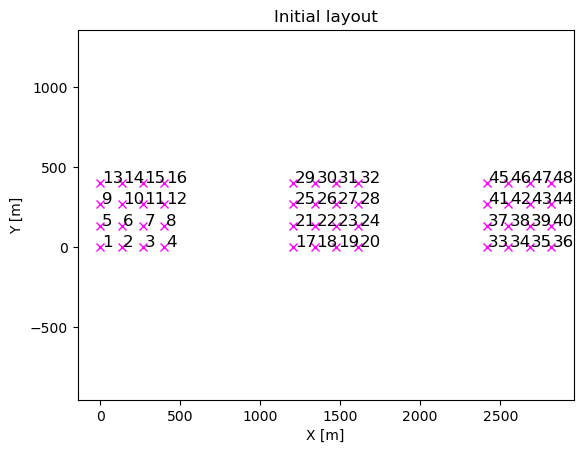

In [7]:
# generate initial positions
grid_size = 4
wt_x1, wt_y1 = np.meshgrid(
    np.linspace(0, wind_turbines.diameter() * grid_size, grid_size),
    np.linspace(0, wind_turbines.diameter() * grid_size, grid_size),
)
wt_x1, wt_y1 = wt_x1.flatten(), wt_y1.flatten()
wt_x2 = wt_x1 + wind_turbines.diameter() * grid_size * 3.0
wt_y2 = wt_y1
wt_y3 = wt_y1 
wt_x3 = wt_x1+ 2* wind_turbines.diameter() * grid_size * 3.0
X_full = np.concatenate([wt_x1, wt_x2, wt_x3])
Y_full = np.concatenate([wt_y1, wt_y2, wt_y3])
n_wt = len(X_full)
print(f"Initial layout has {n_wt} wind turbines")

# plot initial layout
plt.figure()
plt.plot(X_full, Y_full, "x", c="magenta")
# put indeces on the wind turbines
for i in range(n_wt):
    plt.text(X_full[i] + 10, Y_full[i], str(i + 1), fontsize=12)
plt.axis("equal")
# axis title and labels
plt.title("Initial layout")
plt.xlabel("X [m]")
plt.ylabel("Y [m]")


Initial layout has 198 wind turbines


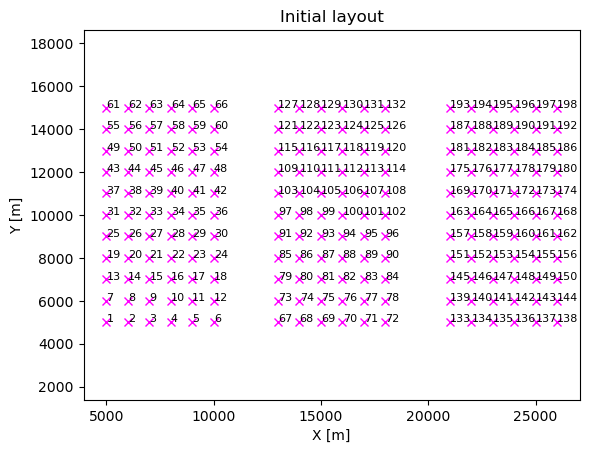

In [5]:
# different initial layout:

# Load your custom .ideal layout
layout_file = "farm_custom.ideal"

turbines = []
with open(layout_file, "r") as f:
    for line in f:
        if line.strip().lower() == "latlon":
            continue  # Skip header
        parts = line.strip().split()
        if len(parts) >= 5:
            n_turbines = float(parts[0])
            y_grid = float(parts[1])
            x_grid = float(parts[2])
            turbines.append((x_grid, y_grid))  # Note: x first for consistency

# Convert to numpy arrays
X_full = np.array([t[0] for t in turbines])
Y_full = np.array([t[1] for t in turbines])
X_full = X_full* 1000.0  # Convert to km
Y_full = Y_full* 1000.0  # Convert to km
n_wt = len(X_full)
print(f"Initial layout has {n_wt} wind turbines")

# plot initial layout
plt.figure()
plt.plot(X_full, Y_full, "x", c="magenta")
# put indeces on the wind turbines, small font so they don't overlap
for i in range(n_wt):
    plt.text(X_full[i] + 10, Y_full[i], str(i + 1), fontsize=8)
plt.axis("equal")
# axis title and labels
plt.title("Initial layout")
plt.xlabel("X [m]")
plt.ylabel("Y [m]")
plt.show()

In [6]:
# Split the full layout into 3 farm groups
n_per_group = n_wt // 3

wt_x1, wt_y1 = X_full[:n_per_group], Y_full[:n_per_group]
wt_x2, wt_y2 = X_full[n_per_group:2 * n_per_group], Y_full[n_per_group:2 * n_per_group]
wt_x3, wt_y3 = X_full[2 * n_per_group:], Y_full[2 * n_per_group:]


# Create a TopFarmProblem instance


Create masks designating which turbines are assigned to which farm

In [7]:
n_wt_sf = n_wt // 3
wf1_mask = np.zeros(n_wt, dtype=bool)
wf1_mask[:n_wt_sf] = True
wf2_mask = np.zeros(n_wt, dtype=bool)
wf2_mask[n_wt_sf : n_wt_sf * 2] = True
wf3_mask = ~(wf1_mask | wf2_mask)  # the rest of turbines

print(f"Turbines belonging to wind farm 1: {np.where(wf1_mask)[0]}")
print(f"Turbines belonging to wind farm 2: {np.where(wf2_mask)[0]}")
print(f"Turbines belonging to wind farm 3: {np.where(wf3_mask)[0]}")

Turbines belonging to wind farm 1: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65]
Turbines belonging to wind farm 2: [ 66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83
  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101
 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119
 120 121 122 123 124 125 126 127 128 129 130 131]
Turbines belonging to wind farm 3: [132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149
 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167
 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185
 186 187 188 189 190 191 192 193 194 195 196 197]


Construct a constraint object from the masks and initial layouts. You can choose which type of constraint to create from available enum options in ConstraintType. There are two options: circular or convex hull constraint. You can change `constr_type` variable and run optimization once more with different constaint type.

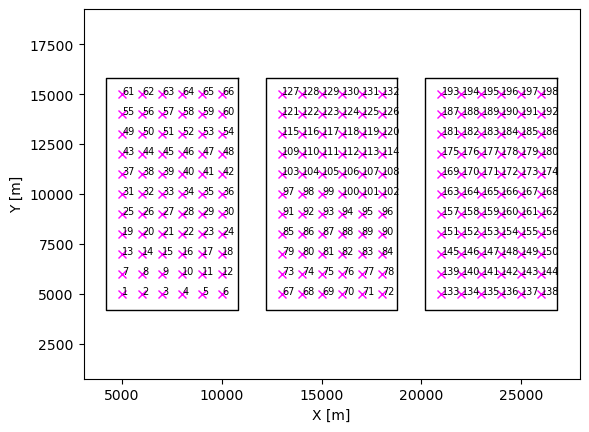

In [64]:
# utility functions to construct the boundary constraint
def _get_radius(x, y):  # fmt: skip
    return np.sqrt((x - x.mean()) ** 2 + (y - y.mean()) ** 2).max() + 100
def _get_center(x, y):  # fmt: skip
    return np.array([x.mean(), y.mean()])
"""
def _get_corners(x: np.ndarray, y: np.ndarray, radius, stype='rect'):  # fmt: skip
    cx = x.mean()
    cy = y.mean()
    if stype == "rect":
        return np.array(
            [
                [cx + radius, cy + radius],
                [cx - radius, cy - radius],
                [cx + radius, cy - radius],
                [cx - radius, cy + radius],
            ]
        )
    if stype == "rot":
        return np.array(
            [
                [cx, cy + radius],
                [cx + radius, cy],
                [cx, cy - radius],
                [cx - radius, cy],
            ]
        )
    if stype == "hex":
        return np.array(
            [
                [cx + radius, cy],
                [cx + radius / 2, cy + radius * np.sqrt(3) / 2],
                [cx - radius / 2, cy + radius * np.sqrt(3) / 2],
                [cx - radius, cy],
                [cx - radius / 2, cy - radius * np.sqrt(3) / 2],
                [cx + radius / 2, cy - radius * np.sqrt(3) / 2],
            ]
        )
    raise ValueError(f"Unknown shape type: {stype}")
"""
def _get_corners(x: np.ndarray, y: np.ndarray, pad_x=700, pad_y=700):
    """Construct rectangle corners tightly around points with custom padding."""
    xmin, xmax = x.min(), x.max()
    ymin, ymax = y.min(), y.max()
    
    return np.array([
        [xmax + pad_x, ymax + pad_y],
        [xmin - pad_x, ymax + pad_y],
        [xmax + pad_x, ymin - pad_y],
        [xmin - pad_x, ymin - pad_y],
    ])

constr_type = BoundaryType.CONVEX_HULL  # or BoundaryType.CONVEX_HULL
wt_groups = [
    np.arange(n_wt // 3),
    np.arange(n_wt // 3, n_wt // 3 * 2),
    np.arange(n_wt // 3 * 2, n_wt),
]
"""
if constr_type == BoundaryType.CIRCLE:
    constraint_comp = MultiWFBoundaryConstraint(
        geometry=[
            (_get_center(wt_x1, wt_y1), _get_radius(wt_x1, wt_y1)),
            (_get_center(wt_x2, wt_y2), _get_radius(wt_x2, wt_y2)),
            (_get_center(wt_x3, wt_y3), _get_radius(wt_x3, wt_y3)),
        ],
        wt_groups=wt_groups,
        boundtype=constr_type,
    )
elif constr_type == BoundaryType.CONVEX_HULL:
    radius = (
        np.sqrt((wt_x1 - wt_x1.mean()) ** 2 + (wt_y1 - wt_y1.mean()) ** 2).max() + 150
    )
    constraint_comp = MultiWFBoundaryConstraint(
        geometry=[
            _get_corners(wt_x1, wt_y1, radius, stype="rect"),
            _get_corners(wt_x2, wt_y2, radius, stype="rect"),
            _get_corners(wt_x3, wt_y3, radius, stype="rect"),
        ],
        wt_groups=wt_groups,
        boundtype=constr_type,
    )
else:
    raise ValueError(f"Unknown constraint type: {constr_type}")
"""
pad_x, pad_y = 800, 800  # padding in meters
if constr_type == BoundaryType.CONVEX_HULL:
    constraint_comp = MultiWFBoundaryConstraint(
        geometry=[
            _get_corners(wt_x1, wt_y1, pad_x, pad_y),
            _get_corners(wt_x2, wt_y2, pad_x, pad_y),
            _get_corners(wt_x3, wt_y3, pad_x, pad_y),
        ],
        wt_groups=wt_groups,
        boundtype=constr_type,
    )


# let's see how the boundaries look like
fig = plt.figure()
ax1 = fig.add_subplot(111)
plt.plot(X_full, Y_full, "x", c="magenta")
for i in range(n_wt):
    plt.text(X_full[i] + 10, Y_full[i], str(i + 1), fontsize=7)
plt.axis("equal")
constraint_comp.get_comp(n_wt).plot(ax1)
plt.xlabel("X [m]")
plt.ylabel("Y [m]")
plt.show()

x_init = X_full.copy()
y_init = Y_full.copy()

Setup cost model based on PyWake AEP. There are two different options here, to be used with Stohastic Gradient Decent (SGD) or Sequential Least Squares Programming (SLSQP) optimization algorithms. Due to stochastic nature of SGD one can sample part of the full wind speeds and directions and compute AEP on partial observations.

In [65]:
import xarray as xr
import pandas as pd

wp0 = xr.open_dataset("C:\\Users\\annem\\OneDrive - Danmarks Tekniske Universitet\\General\\Testing_materials\\Data_Share\\condense_WP0.nc")
wp1 = xr.open_dataset("C:\\Users\\annem\\OneDrive - Danmarks Tekniske Universitet\\General\\Testing_materials\\Data_Share\\condense_WP1.nc")
timestamps = wp0.time.values 
months = pd.to_datetime(timestamps).month  
full_wd = np.arange(0, 360, 5)  # wind directions
full_ws = np.arange(3, 25, 1)  # wind speeds

# Extract wind speed and wind direction from wp0
#ws = wp0.WS.isel(time=0, height=3)  # Select wind speed at 150m height, for the first time step
#wd = wp0.WD.isel(time=0, height=3)  # Select wind direction at 150m height, for the first time step
ws = wp0.WS.isel(time=0, height=3).values.flatten()  # shape (N,) -> all turbines
wd = wp0.WD.isel(time=0, height=3).values.flatten()  # shape (N,) -> all turbines

print(ws.shape, wd.shape)

"""
# Convert wind direction (WD) from degrees to radians
wd_rad = np.deg2rad(wd)

# Convert wind speed and direction to u and v components (east-west and north-south components)
u = -ws * np.sin(wd_rad)  # u-component (east-west)
v = -ws * np.cos(wd_rad)  # v-component (north-south)

mean_u = np.mean(u)  # Mean u-component
mean_v = np.mean(v)  # Mean v-component

# take average and add perturbations, take into account the wind direction circularity
mean_ws = np.mean(ws)
meanwd_rad = np.arctan2(mean_u, mean_v)  # Mean wind direction in radians
mean_wd = np.rad2deg(meanwd_rad)  # Convert back to degrees
mean_wd = (mean_wd + 360) % 360  # Ensure wind direction is between 0 and 360 degrees
print('mean_u:', mean_u)
print('mean_v:', mean_v)
print('mean_ws:', mean_ws)
print('mean_wd:', mean_wd)


#print(f"Central wind speed: {mean_ws_center}")
perturbation_factor_ws = 0.5
perturbation_factor_wd = 5  # Change this factor to control the range of perturbation
#mean_ws_perturbed = mean_ws + np.random.normal(scale=perturbation_factor)
#ws_array = np.array([mean_ws_perturbed])
#mean_ws_perturbed = mean_ws_center + np.random.normal(scale=perturbation_factor)  # Perturb the mean

# Apply unique perturbations to each wind speed and direction
ws_perturbed = mean_ws + np.random.normal(scale=perturbation_factor_ws, size=full_ws.shape)
wd_perturbed = mean_wd + np.random.normal(scale=perturbation_factor_wd, size=full_wd.shape)
print('wd_perturbed:', wd_perturbed)
# Clip to ensure wind speeds stay within valid range (3 m/s to 25 m/s)
ws_perturbed = np.clip(ws_perturbed, 3, 25)

# Clip to ensure wind directions stay within valid range (0° to 360°)
wd_perturbed = np.clip(wd_perturbed, 0, 360)
print('Perturbed mean wind speed:', ws_perturbed)
print('Perturbed mean wind direction:', wd_perturbed)

# Plotting the original and perturbed wind speeds
plt.figure(figsize=(8, 6))
plt.plot(ws, label="Original Wind Speed", color='blue')  # Original data
plt.axhline(mean_ws, label="Mean Wind Speed", linestyle='--', color='green')  # Horizontal line for mean
plt.plot(ws_perturbed, label="Perturbed Wind Speed (Mean)", linestyle='--', color='red')  # Perturbed mean
plt.xlabel("Turbine Index")
plt.ylabel("Wind Speed (m/s)")
plt.title("Wind Speed Perturbation")
plt.legend()
plt.grid()
plt.show()
"""

(2925,) (2925,)


'\n# Convert wind direction (WD) from degrees to radians\nwd_rad = np.deg2rad(wd)\n\n# Convert wind speed and direction to u and v components (east-west and north-south components)\nu = -ws * np.sin(wd_rad)  # u-component (east-west)\nv = -ws * np.cos(wd_rad)  # v-component (north-south)\n\nmean_u = np.mean(u)  # Mean u-component\nmean_v = np.mean(v)  # Mean v-component\n\n# take average and add perturbations, take into account the wind direction circularity\nmean_ws = np.mean(ws)\nmeanwd_rad = np.arctan2(mean_u, mean_v)  # Mean wind direction in radians\nmean_wd = np.rad2deg(meanwd_rad)  # Convert back to degrees\nmean_wd = (mean_wd + 360) % 360  # Ensure wind direction is between 0 and 360 degrees\nprint(\'mean_u:\', mean_u)\nprint(\'mean_v:\', mean_v)\nprint(\'mean_ws:\', mean_ws)\nprint(\'mean_wd:\', mean_wd)\n\n\n#print(f"Central wind speed: {mean_ws_center}")\nperturbation_factor_ws = 0.5\nperturbation_factor_wd = 5  # Change this factor to control the range of perturbation\n#mea

In [66]:
# Define your two seasonal periods
seasons = {
    "April–October": list(range(4, 11)),      # months 4 to 10
    "November–March": [11, 12, 1, 2, 3]        # wrap-around months
}

summer_wind = wp0.sel(time=wp0['time.month'].isin(range(4, 11)))
winter_wind = wp0.sel(time=wp0['time.month'].isin([11, 12, 1, 2, 3]))
year_wind = wp0.sel(time=wp0['time.month'].isin(range(1, 13)))
ws = wp0.WS.isel(time=0, height=3).values.flatten()  # shape (N,) -> all turbines
wd = wp0.WD.isel(time=0, height=3).values.flatten()  # shape (N,) -> all turbines
X = X_full
Y = Y_full


In [14]:
from scipy.stats import weibull_min
import time


chunk_size = 1000  # or 5000 depending on your RAM

# Just take a slice instead of the whole time range
summer_ws = summer_wind.WS.isel(height=3, time=slice(0, chunk_size)).load().values.flatten()
summer_wd = summer_wind.WD.isel(height=3, time=slice(0, chunk_size)).load().values.flatten()
winter_ws = winter_wind.WS.isel(height=3, time=slice(0, chunk_size)).load().values.flatten()
winter_wd = winter_wind.WD.isel(height=3, time=slice(0, chunk_size)).load().values.flatten()
year_ws = year_wind.WS.isel(height=3, time=slice(0, chunk_size)).load().values.flatten()
year_wd = year_wind.WD.isel(height=3, time=slice(0, chunk_size)).load().values.flatten()

# Extract real WS and WD data from summer_wind and winter_wind
ws_summer = summer_wind.WS.isel(height=3).values.flatten()
wd_summer = summer_wind.WD.isel(height=3).values.flatten()
mask = ~np.isnan(ws_summer) & ~np.isnan(wd_summer)
ws_summer = ws_summer[mask]
wd_summer = wd_summer[mask]

# Same for winter
ws_winter = winter_wind.WS.isel(height=3).load().values.flatten()
wd_winter = winter_wind.WD.isel(height=3).load().values.flatten()
mask_winter = ~np.isnan(ws_winter) & ~np.isnan(wd_winter)
ws_winter = ws_winter[mask_winter]
wd_winter = wd_winter[mask_winter]

# for year
ws_year = year_wind.WS.isel(height=3).load().values.flatten()
wd_year = year_wind.WD.isel(height=3).load().values.flatten()
mask_year = ~np.isnan(ws_year) & ~np.isnan(wd_year)
ws_year = ws_year[mask_year]
wd_year = wd_year[mask_year]

# Compute histograms for frequency distribution
print('making histograms')
freqs_summer, _ = np.histogram(wd_summer, bins=np.append(full_wd, 360))
freqs_summer = freqs_summer / freqs_summer.sum()

freqs_winter, _ = np.histogram(wd_winter, bins=np.append(full_wd, 360))
freqs_winter = freqs_winter / freqs_winter.sum()

freqs_year, _ = np.histogram(wd_year, bins=np.append(full_wd, 360))
freqs_year = freqs_year / freqs_year.sum()

# Fit Weibull distribution for each direction bin
def fit_weibull_per_bin(wd, ws, bins):
    A_list, k_list = [], []
    for i in range(len(bins)):
        start = time.time()
        lower = bins[i]
        upper = bins[i] + 1
        idx = (wd >= lower) & (wd < upper)
        ws_bin = ws[idx]
        if len(ws_bin) > 0:
            c, loc, scale = weibull_min.fit(ws_bin, floc=0)
            print(f"Bin {i}: fit done in {time.time() - start:.2f} sec")
            k_list.append(c)
            A_list.append(scale)
        else:
            k_list.append(2)
            A_list.append(8)
    return np.array(A_list), np.array(k_list)

# Fit Weibull to WS per wind direction bin
As_summer, ks_summer = fit_weibull_per_bin(wd_summer, ws_summer, full_wd)
As_winter, ks_winter = fit_weibull_per_bin(wd_winter, ws_winter, full_wd)
As_year, ks_year = fit_weibull_per_bin(wd_year, ws_year, full_wd)

# Convert to numpy arrays
print('Converting to numpy arrays')
As_summer = np.array(As_summer)
ks_summer = np.array(ks_summer)
As_winter = np.array(As_winter)
ks_winter = np.array(ks_winter)
As_year = np.array(As_year)
ks_year = np.array(ks_year)


making histograms
Bin 0: fit done in 0.30 sec
Bin 1: fit done in 0.11 sec
Bin 2: fit done in 0.10 sec
Bin 3: fit done in 0.10 sec
Bin 4: fit done in 0.09 sec
Bin 5: fit done in 0.09 sec
Bin 6: fit done in 0.08 sec
Bin 7: fit done in 0.07 sec
Bin 8: fit done in 0.08 sec
Bin 9: fit done in 0.08 sec
Bin 10: fit done in 0.09 sec
Bin 11: fit done in 0.08 sec
Bin 12: fit done in 0.10 sec
Bin 13: fit done in 0.09 sec
Bin 14: fit done in 0.10 sec
Bin 15: fit done in 0.14 sec
Bin 16: fit done in 0.11 sec
Bin 17: fit done in 0.10 sec
Bin 18: fit done in 0.09 sec
Bin 19: fit done in 0.09 sec
Bin 20: fit done in 0.07 sec
Bin 21: fit done in 0.08 sec
Bin 22: fit done in 0.08 sec
Bin 23: fit done in 0.08 sec
Bin 24: fit done in 0.08 sec
Bin 25: fit done in 0.07 sec
Bin 26: fit done in 0.07 sec
Bin 27: fit done in 0.08 sec
Bin 28: fit done in 0.08 sec
Bin 29: fit done in 0.08 sec
Bin 30: fit done in 0.07 sec
Bin 31: fit done in 0.08 sec
Bin 32: fit done in 0.08 sec
Bin 33: fit done in 0.08 sec
Bin 34

In [15]:
np.save("As_summer.npy", As_summer)
np.save("ks_summer.npy", ks_summer)
np.save("freqs_summer.npy", freqs_summer)

np.save("As_winter.npy", As_winter)
np.save("ks_winter.npy", ks_winter)
np.save("freqs_winter.npy", freqs_winter)

np.save("As_year.npy", As_year)
np.save("ks_year.npy", ks_year)
np.save("freqs_year.npy", freqs_year)

In [67]:
As_summer.mean(), ks_summer.mean()
As_winter.mean(), ks_winter.mean()
As_year.mean(), ks_year.mean()
print('As_summer:', As_summer.mean(), 'ks_summer:', ks_summer.mean())
print('As_winter:', As_winter.mean(), 'ks_winter:', ks_winter.mean())
print('As_year:', As_year.mean(), 'ks_year:', ks_year.mean())

As_summer: 6.4734405761452 ks_summer: 2.312804943008935
As_winter: 6.310990069438027 ks_winter: 2.1327550714387806
As_year: 7.699522602839876 ks_year: 2.363312318207889


In [17]:
"""
np.random.seed(42)
# Wind Resouces

freqs = site.local_wind(  # sector frequencies
    X_full,
    Y_full,
    wd=wd_perturbed,
    ws=ws_perturbed,
).Sector_frequency_ilk[0, :, 0]
# weibull parameters
As = site.local_wind(X_full, Y_full, wd=wd_perturbed, ws=ws_perturbed).Weibull_A_ilk[0, :, 0]
ks = site.local_wind(X_full, Y_full, wd=wd_perturbed, ws=ws_perturbed).Weibull_k_ilk[0, :, 0]
N_SAMPLES = 25  # play with the number of samples

# sample wind resources
def wind_resource_sample():
    idx = np.random.choice(np.arange(wd_perturbed.size), N_SAMPLES, p=freqs / freqs.sum())
    wd = wd_perturbed[idx]
    ws = As[idx] * np.random.weibull(ks[idx])
    return wd, ws


# aep function - SGD
def aep_func(x, y, full=False, **kwargs):
    wd, ws = wind_resource_sample() if not full else (wd_perturbed, ws_perturbed)
    aep_sgd = wf_model(x, y, wd=wd, ws=ws, time=not full).aep().sum().values * 1e6
    return aep_sgd


# gradient function - SGD
def aep_jac(x, y, **kwargs):
    wd, ws = wind_resource_sample()
    jx, jy = wf_model.aep_gradients(
        gradient_method=autograd, wrt_arg=["x", "y"], x=x, y=y, ws=ws, wd=wd, time=True
    )
    daep_sgd = np.array([np.atleast_2d(jx), np.atleast_2d(jy)]) * 1e6
    return daep_sgd


# AEP Cost Model Component - SGD
sgd_cost_comp = AEPCostModelComponent(
    input_keys=[topfarm.x_key, topfarm.y_key],
    n_wt=n_wt,
    cost_function=aep_func,
    cost_gradient_function=aep_jac,
)

# AEP Cost Model Component - SLSQP
slsqp_cost_comp = PyWakeAEPCostModelComponent(
    windFarmModel=wf_model, n_wt=n_wt, grad_method=autograd
)
"""

'\nnp.random.seed(42)\n# Wind Resouces\n\nfreqs = site.local_wind(  # sector frequencies\n    X_full,\n    Y_full,\n    wd=wd_perturbed,\n    ws=ws_perturbed,\n).Sector_frequency_ilk[0, :, 0]\n# weibull parameters\nAs = site.local_wind(X_full, Y_full, wd=wd_perturbed, ws=ws_perturbed).Weibull_A_ilk[0, :, 0]\nks = site.local_wind(X_full, Y_full, wd=wd_perturbed, ws=ws_perturbed).Weibull_k_ilk[0, :, 0]\nN_SAMPLES = 25  # play with the number of samples\n\n# sample wind resources\ndef wind_resource_sample():\n    idx = np.random.choice(np.arange(wd_perturbed.size), N_SAMPLES, p=freqs / freqs.sum())\n    wd = wd_perturbed[idx]\n    ws = As[idx] * np.random.weibull(ks[idx])\n    return wd, ws\n\n\n# aep function - SGD\ndef aep_func(x, y, full=False, **kwargs):\n    wd, ws = wind_resource_sample() if not full else (wd_perturbed, ws_perturbed)\n    aep_sgd = wf_model(x, y, wd=wd, ws=ws, time=not full).aep().sum().values * 1e6\n    return aep_sgd\n\n\n# gradient function - SGD\ndef aep_jac(x, 

In [68]:
np.random.seed(42)
N_SAMPLES = 1000  # play with the number of samples

# Get the wind resources for the three seasons
def summer_resource_sample(As, ks, freqs):
    idx = np.random.choice(np.arange(len(full_wd)), N_SAMPLES, p=freqs_summer)
    wd = full_wd[idx]
    ws = As_summer[idx] * np.random.weibull(ks_summer[idx])
    return wd, ws
def winter_resource_sample(As, ks, freqs):
    idx = np.random.choice(np.arange(len(full_wd)), N_SAMPLES, p=freqs_winter)
    wd = full_wd[idx]
    ws = As_winter[idx] * np.random.weibull(ks_winter[idx])
    return wd, ws
def wind_resource_sample(As, ks, freqs):
    idx = np.random.choice(np.arange(len(full_wd)), N_SAMPLES, p=freqs)
    wd = full_wd[idx]
    ws = As[idx] * np.random.weibull(ks[idx])
    return wd, ws
def year_resource_sample(As, ks, freqs):
    idx = np.random.choice(np.arange(len(full_wd)), N_SAMPLES, p=freqs_year)
    wd = full_wd[idx]
    ws = As_year[idx] * np.random.weibull(ks_year[idx])
    return wd, ws

# --- Zomer AEP-componenten ---
def aep_func_summer(x, y, full=False, **kwargs):
    wd, ws = wind_resource_sample(As_summer, ks_summer, freqs_summer) if not full else (full_wd, As_summer)
    aep = wf_model(x, y, wd=wd, ws=ws, time=not full).aep().sum().values * 1e6
    return aep

def aep_jac_summer(x, y, **kwargs):
    wd, ws = wind_resource_sample(As_summer, ks_summer, freqs_summer)
    jx, jy = wf_model.aep_gradients(
        gradient_method=autograd, wrt_arg=["x", "y"], x=x, y=y, ws=ws, wd=wd, time=True
    )
    return np.array([np.atleast_2d(jx), np.atleast_2d(jy)]) * 1e6

sgd_cost_comp_summer = AEPCostModelComponent(
    input_keys=[topfarm.x_key, topfarm.y_key],
    n_wt=n_wt,
    cost_function=aep_func_summer,
    cost_gradient_function=aep_jac_summer,
)

# --- Winter AEP-componenten ---
def aep_func_winter(x, y, full=False, **kwargs):
    wd, ws = wind_resource_sample(As_winter, ks_winter, freqs_winter) if not full else (full_wd, As_winter)
    aep = wf_model(x, y, wd=wd, ws=ws, time=not full).aep().sum().values * 1e6
    return aep

def aep_jac_winter(x, y, **kwargs):
    wd, ws = wind_resource_sample(As_winter, ks_winter, freqs_winter)
    jx, jy = wf_model.aep_gradients(
        gradient_method=autograd, wrt_arg=["x", "y"], x=x, y=y, ws=ws, wd=wd, time=True
    )
    return np.array([np.atleast_2d(jx), np.atleast_2d(jy)]) * 1e6

sgd_cost_comp_winter = AEPCostModelComponent(
    input_keys=[topfarm.x_key, topfarm.y_key],
    n_wt=n_wt,
    cost_function=aep_func_winter,
    cost_gradient_function=aep_jac_winter,
)

# --- Year AEP-componenten ---
def aep_func_year(x, y, full=False, **kwargs):
    wd, ws = wind_resource_sample(As_year, ks_year, freqs_year) if not full else (full_wd, As_year)
    aep = wf_model(x, y, wd=wd, ws=ws, time=not full).aep().sum().values * 1e6
    return aep

def aep_jac_year(x, y, **kwargs):
    wd, ws = wind_resource_sample(As_year, ks_year, freqs_year)
    jx, jy = wf_model.aep_gradients(
        gradient_method=autograd, wrt_arg=["x", "y"], x=x, y=y, ws=ws, wd=wd, time=True
    )
    return np.array([np.atleast_2d(jx), np.atleast_2d(jy)]) * 1e6

sgd_cost_comp_year = AEPCostModelComponent(
    input_keys=[topfarm.x_key, topfarm.y_key],
    n_wt=n_wt,
    cost_function=aep_func_year,
    cost_gradient_function=aep_jac_year,
)



# Dont use this, since using sgd
slsqp_cost_comp_summer = PyWakeAEPCostModelComponent(
    windFarmModel=wf_model, n_wt=n_wt, grad_method=autograd
)
slsqp_cost_comp_winter = PyWakeAEPCostModelComponent(
    windFarmModel=wf_model, n_wt=n_wt, grad_method=autograd
)
slsqp_cost_comp_year = PyWakeAEPCostModelComponent(
    windFarmModel=wf_model, n_wt=n_wt, grad_method=autograd
)


In [69]:
# Optimizing for stability
def stability_objective(x, y):
    aep_summer = wf_model(x, y, wd=wd_summer, ws=ws_summer).aep().sum().values
    aep_winter = wf_model(x, y, wd=wd_winter, ws=ws_winter).aep().sum().values
    aep_year = wf_model(x, y, wd=wd_year, ws=ws_year).aep().sum().values
    # Objective: minimize absolute seasonal difference (you could also use squared diff or ratio)
    stability_penalty = np.abs(aep_summer - aep_winter)
    return stability_penalty

# optimizing for stability together with AEP
def aep_stability_combo(x, y, alpha=0.8):
    # alpha controls weight: 1 = only AEP, 0 = only stability
    aep_year = wf_model(x, y, wd=wd_year, ws=ws_year).aep().sum().values
    aep_summer = wf_model(x, y, wd=wd_summer, ws=ws_summer).aep().sum().values
    aep_winter = wf_model(x, y, wd=wd_winter, ws=ws_winter).aep().sum().values
    seasonal_std = np.std([aep_summer, aep_winter])
    return -alpha * aep_year + (1 - alpha) * seasonal_std  # minimize seasonal fluctuation, maximize AEP

stability_cost_comp = CostModelComponent(
    input_keys=["x", "y"],
    n_wt=n_wt,
    cost_function=aep_stability_combo,  # your function!
)

Setup a driver to be used in optimization. You can try running with either of SLSQP or SGD by changing the driver type.

In [70]:
driver_type = "SGD"  # "SLSQP" or "SGD"
min_spacing = wind_turbines.diameter() * 3

season ='year'  # 'summer' or 'winter' 
# optimize for summer, winter and full year 

if driver_type == "SLSQP":
    constraints = [
        constraint_comp,
        SpacingConstraint(min_spacing=min_spacing),
    ]
    driver = EasyScipyOptimizeDriver(
        optimizer="SLSQP",
        # might not be enough for the optimizer to converge
        maxiter=30,
    )
    cost_comp = slsqp_cost_comp_summer if season == 'summer' else slsqp_cost_comp_winter if season == 'winter' else slsqp_cost_comp_year
elif driver_type == "SGD":
    constraints = DistanceConstraintAggregation(
        constraint_comp,
        n_wt=n_wt,
        min_spacing_m=min_spacing,
        windTurbines=wind_turbines,
    )
    driver = EasySGDDriver(
        # might not be enough for the optimizer to converge
        maxiter=30,
        speedupSGD=True,
        learning_rate=wind_turbines.diameter() / 5,
        gamma_min_factor=0.1,
    )
    #cost_comp = sgd_cost_comp (# from example)
    cost_comp = sgd_cost_comp_summer if season == 'summer' else sgd_cost_comp_winter if season == 'winter' else sgd_cost_comp_year
    #cost_comp = stability_cost_comp
else:
    raise ValueError(f"Unknown driver: {driver_type}")

In [ ]:
"""
driver_type = "SGD"  # "SLSQP" or "SGD"
min_spacing = wind_turbines.diameter() * 2
layouts = {}
#season ='year'  # 'summer' or 'winter' 
# optimize for summer, winter and full year 
for season in ['summer', 'winter', 'year']:
    print(f"Optimizing for {season} season")

    if driver_type == "SLSQP":
        constraints = [
            constraint_comp,
            SpacingConstraint(min_spacing=min_spacing),
        ]
        driver = EasyScipyOptimizeDriver(
            optimizer="SLSQP",
            # might not be enough for the optimizer to converge
            maxiter=30,
        )
        cost_comp = slsqp_cost_comp_summer if season == 'summer' else slsqp_cost_comp_winter if season == 'winter' else slsqp_cost_comp_year
    elif driver_type == "SGD":
        constraints = DistanceConstraintAggregation(
            constraint_comp,
            n_wt=n_wt,
            min_spacing_m=min_spacing,
            windTurbines=wind_turbines,
        )
        driver = EasySGDDriver(
            # might not be enough for the optimizer to converge
            maxiter=30,
            speedupSGD=True,
            learning_rate=wind_turbines.diameter() / 5,
            gamma_min_factor=0.1,
        )
        cost_comp = {
        'summer': sgd_cost_comp_summer,
        'winter': sgd_cost_comp_winter,
        'year': sgd_cost_comp_year
    }[season]

    problem = TopFarmProblem(
        design_vars={"x": X_full, "y": Y_full},
        n_wt=n_wt,
        constraints=constraints,
        cost_comp=cost_comp,
        driver=driver,
        plot_comp=XYPlotComp(),
    )
    cost, state, recorder = problem.optimize(disp=True)

    # Store the optimized layouts
    rec = recorder.copy()
    layouts[season] = {
    'x': rec["x"][-1],
    'y': rec["y"][-1],
    'aep': aep_func_year_eval(rec["x"][-1], rec["y"][-1])  # evaluate each on full-year
    }

    print(f"Optimized layout for {season} season:")
    print(f"First X: {recorder['x'][0][:5]}")
    print(f"Last X: {recorder['x'][-1][:5]}")

"""

Setup TopFarmProblem object and run the optimization. 

Due to sampling in the SGD AEP computation the final AEP result in the plot will not reflect the actual improvement in AEP. Thus it is necessary to compute AEP boost later on in the notebook.

(As, ks, freqs)
INFO: checking out_of_order...
INFO:     out_of_order check complete (0.004130 sec).
INFO: checking system...
INFO:     system check complete (0.000155 sec).
INFO: checking solvers...
INFO:     solvers check complete (0.000566 sec).
INFO: checking dup_inputs...
INFO:     dup_inputs check complete (0.000141 sec).
INFO: checking missing_recorders...
INFO:     missing_recorders check complete (0.000154 sec).
INFO: checking unserializable_options...
INFO:     unserializable_options check complete (0.009026 sec).
INFO: checking comp_has_no_outputs...
INFO:     comp_has_no_outputs check complete (0.000506 sec).
INFO: checking auto_ivc_warnings...
INFO:     auto_ivc_warnings check complete (0.000015 sec).
INFO: checking out_of_order...
INFO:     out_of_order check complete (0.001391 sec).
INFO: checking system...
INFO:     system check complete (0.000053 sec).
INFO: checking solvers...
INFO:     solvers check complete (0.000344 sec).
INFO: checking dup_inputs...
INFO:     dup_

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


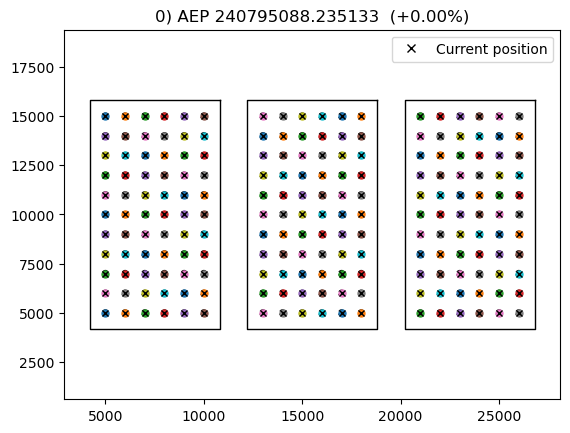

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


Optimized in	531.039s


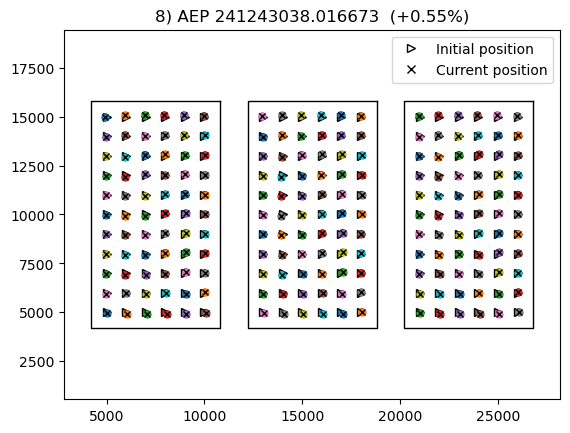

In [ ]:
import inspect
print(inspect.signature(wind_resource_sample))

problem = TopFarmProblem(
    design_vars={"x": X_full, "y": Y_full},
    n_wt=n_wt,
    constraints=constraints,
    cost_comp=cost_comp,
    driver=driver,
    plot_comp=XYPlotComp(),
)

cost, state, recorder = problem.optimize(disp=True)
fig = plt.gcf()
fig.savefig(f"optimized_plot_{season}.png", dpi=300, bbox_inches='tight')

In [59]:
def aep_func_year_eval(x, y):
    return wf_model(x, y, wd=full_wd, ws=As_year, time=True).aep().sum().values * 1e6
final_x = recorder["x"][-1]
final_y = recorder["y"][-1]

if season == 'summer':
    x_summer = final_x
    y_summer = final_y
    aep_year_summer = aep_func_year_eval(x_summer, y_summer)
    print('AEP summer:', aep_year_summer)
elif season == 'winter':
    x_winter = final_x
    y_winter = final_y
    aep_year_winter = aep_func_year_eval(x_winter, y_winter)
    print('AEP winter:', aep_year_winter)
else:
    x_year = final_x
    y_year = final_y
    aep_year = aep_func_year_eval(x_year, y_year)
    print('AEP year:', aep_year)

# Path to save the .ideal file and use the give season and sample size
output_file = f"optimized_layout_{season}_{N_SAMPLES}.ideal"

# Write to file
with open(output_file, "w") as f:
    f.write("latlon\n")
    for x, y in zip(final_x, final_y):
        f.write(f"1 {y/1000:.3f} {x/1000:.3f} NREL-15MW-242 1\n")

print(f"Layout saved to: {output_file}")


AEP year: 244785650.31591865
Layout saved to: optimized_layout_year_1000.ideal


In [60]:


initial_aep = aep_func_year_eval(x_init, y_init)
final_aep = aep_func_year_eval(x_summer if season == 'summer' else x_winter if season == 'winter' else x_year,
                                y_summer if season == 'summer' else y_winter if season == 'winter' else y_year)
final_aep = aep_func_year_eval(recorder["x"][-1], recorder["y"][-1])
print(f"Initial AEP: {initial_aep:.2f} MWh")
print(f"Final AEP: {final_aep:.2f} MWh")
print(f"AEP relative improvement: {(final_aep - initial_aep) / initial_aep * 100:.2f}% for {season}")


"""
if season == 'summer':
    np.random.seed(42)
    initial_aep = aep_func_summer(recorder["x"][0], recorder["y"][0], full=True)
    np.random.seed(42)
    final_aep = aep_func_summer(recorder["x"][-1], recorder["y"][-1], full=True)
    print(f"AEP relative improvement: {(final_aep - initial_aep) / initial_aep * 100:.2f}%")
elif season == 'winter':
    np.random.seed(42)
    initial_aep = aep_func_year_eval(x_init, y_init)    
    np.random.seed(42)
    final_aep = aep_func_year_eval(x_winter, y_winter)
    print(f"AEP relative improvement: {(final_aep - initial_aep) / initial_aep * 100:.2f}%")
else:
    # For the full year
    np.random.seed(42)
    initial_aep = aep_func_year(recorder["x"][0], recorder["y"][0], full=True)
    np.random.seed(42)
    final_aep = aep_func_year(recorder["x"][-1], recorder["y"][-1], full=True)
    print(f"AEP relative improvement: {(final_aep - initial_aep) / initial_aep * 100:.2f}%")
    
"""

Initial AEP: 244742602.51 MWh
Final AEP: 244785650.32 MWh
AEP relative improvement: 0.02% for year


'\nif season == \'summer\':\n    np.random.seed(42)\n    initial_aep = aep_func_summer(recorder["x"][0], recorder["y"][0], full=True)\n    np.random.seed(42)\n    final_aep = aep_func_summer(recorder["x"][-1], recorder["y"][-1], full=True)\n    print(f"AEP relative improvement: {(final_aep - initial_aep) / initial_aep * 100:.2f}%")\nelif season == \'winter\':\n    np.random.seed(42)\n    initial_aep = aep_func_year_eval(x_init, y_init)    \n    np.random.seed(42)\n    final_aep = aep_func_year_eval(x_winter, y_winter)\n    print(f"AEP relative improvement: {(final_aep - initial_aep) / initial_aep * 100:.2f}%")\nelse:\n    # For the full year\n    np.random.seed(42)\n    initial_aep = aep_func_year(recorder["x"][0], recorder["y"][0], full=True)\n    np.random.seed(42)\n    final_aep = aep_func_year(recorder["x"][-1], recorder["y"][-1], full=True)\n    print(f"AEP relative improvement: {(final_aep - initial_aep) / initial_aep * 100:.2f}%")\n    \n'

Month: 1
Month: 2
Month: 3
Month: 4
Month: 5
Month: 6
Month: 7
Month: 8
Month: 9
Month: 10
Month: 11
Month: 12


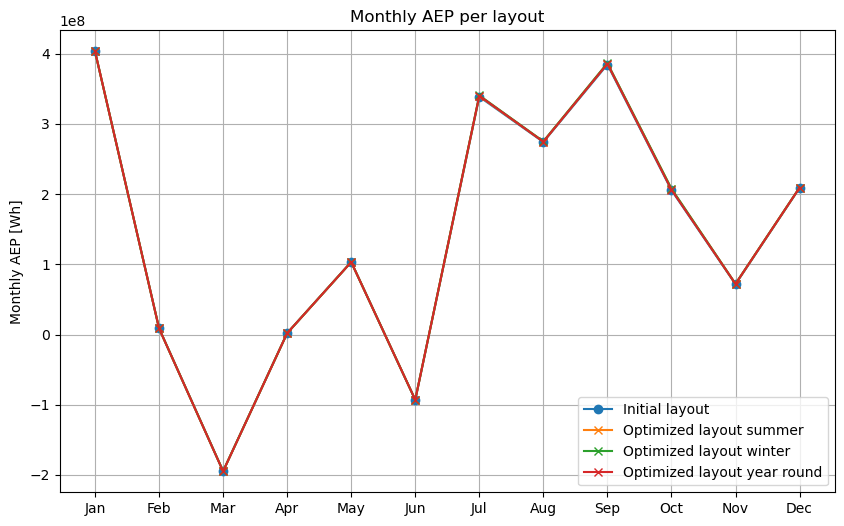

In [ ]:
monthly_aep_init = []
monthly_aep_final_summer = []
monthly_aep_final_winter = []
monthly_aep_final_year = []


for month in range(1, 13):
    print(f"Month: {month}")
    # Get the wind resources for the current month
    # Downsample to N samples per month
    

    month_wind = wp0.sel(time=wp0['time.month'] == month)
    month_ws = month_wind.WS.isel(height=3).values.flatten()
    month_wd = month_wind.WD.isel(height=3).values.flatten()
    N_MONTHLY_SAMPLES = 200  # or 500 depending on what runs on your machine
    if len(month_ws) > N_MONTHLY_SAMPLES:
        idx = np.random.choice(len(month_ws), size=N_MONTHLY_SAMPLES, replace=False)
        month_ws = month_ws[idx]
        month_wd = month_wd[idx]

    mask = ~np.isnan(month_ws) & ~np.isnan(month_wd)
    month_ws = month_ws[mask]
    month_wd = month_wd[mask]
    # get aep for the month for the 4 layouts
    aep_init = wf_model(x_init, y_init, wd=month_wd, ws=month_ws).aep().sum().values * 1e6
    monthly_aep_init.append(aep_init)
    aep_summer = wf_model(x_summer, y_summer, wd=month_wd, ws=month_ws).aep().sum().values * 1e6
    monthly_aep_final_summer.append(aep_summer)
    aep_winter = wf_model(x_winter, y_winter, wd=month_wd, ws=month_ws).aep().sum().values * 1e6    
    monthly_aep_final_winter.append(aep_winter)
    aep_year = wf_model(x_year, y_year, wd=month_wd, ws=month_ws).aep().sum().values * 1e6
    monthly_aep_final_year.append(aep_year)



months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
          "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

plt.figure(figsize=(10,6))
plt.plot(months, monthly_aep_init, label="Initial layout", marker="o")
plt.plot(months, monthly_aep_final_summer, label="Optimized layout summer", marker="x")
plt.plot(months, monthly_aep_final_winter, label="Optimized layout winter", marker="x")
plt.plot(months, monthly_aep_final_year, label="Optimized layout year round", marker="x")
plt.ylabel("Monthly AEP [Wh]")
plt.title("Monthly AEP per layout")
plt.legend()
plt.grid()
plt.show()

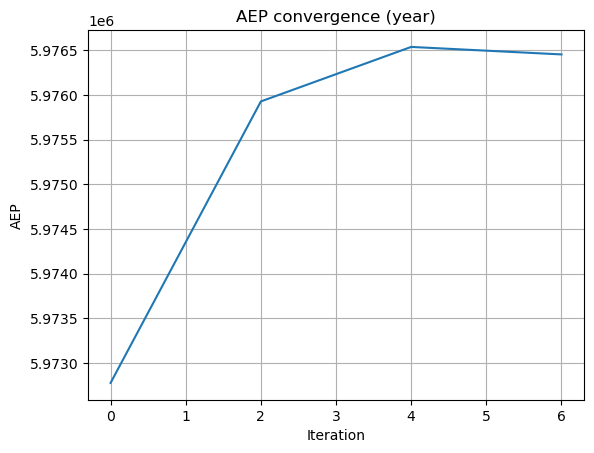

'\naeps = []\niterations = range(len(recorder["x"]))\nfor i in iterations:\n    if i % 2 == 0:\n        continue\n    aeps.append(aep_func_year(recorder["x"][i], recorder["y"][i], full=True))\nplt.figure()\nplt.plot(np.arange(0, len(aeps) * 2, 2), aeps)\nplt.xlabel("Iteration")\nplt.ylabel("AEP")\nplt.title("AEP convergence")\nplt.show()\n\n#summer\naeps_summer = []\niterations = range(len(recorder["x"]))\nfor i in iterations:\n    if i % 2 == 0:\n        continue\n    aeps_summer.append(aep_func_summer(recorder["x"][i], recorder["y"][i], full=True))\nplt.figure()\nplt.plot(np.arange(0, len(aeps_summer) * 2, 2), aeps_summer)\nplt.xlabel("Iteration")\nplt.ylabel("AEP")\nplt.title("AEP convergence (summer)")\nplt.show()\n\n#winter\naeps_winter = []\niterations = range(len(recorder["x"]))\nfor i in iterations:\n    if i % 2 == 0:\n        continue\n    aeps_winter.append(aep_func_winter(recorder["x"][i], recorder["y"][i], full=True))\nplt.figure()\nplt.plot(np.arange(0, len(aeps_winter) *

In [62]:
if season == 'summer':
    aeps = []
    for i in range(len(recorder["x"])):
        if i % 2 == 0:
            continue
        aeps.append(aep_func_summer(recorder["x"][i], recorder["y"][i], full=True))
    plt.figure()
    plt.plot(np.arange(0, len(aeps) * 2, 2), aeps)
    plt.xlabel("Iteration")
    plt.ylabel("AEP")
    plt.title("AEP convergence (summer)")
    plt.grid()
    plt.savefig("AEP_convergence_summer.png")
    plt.show()

elif season == 'winter':
    aeps = []
    for i in range(len(recorder["x"])):
        if i % 2 == 0:
            continue
        aeps.append(aep_func_winter(recorder["x"][i], recorder["y"][i], full=True))
    plt.figure()
    plt.plot(np.arange(0, len(aeps) * 2, 2), aeps)
    plt.xlabel("Iteration")
    plt.ylabel("AEP")
    plt.title("AEP convergence (winter)")
    plt.grid()
    plt.savefig("AEP_convergence_winter.png")
    plt.show()

elif season == 'year':
    aeps = []
    for i in range(len(recorder["x"])):
        if i % 2 == 0:
            continue
        aeps.append(aep_func_year(recorder["x"][i], recorder["y"][i], full=True))
    plt.figure()
    plt.plot(np.arange(0, len(aeps) * 2, 2), aeps)
    plt.xlabel("Iteration")
    plt.ylabel("AEP")
    plt.title("AEP convergence (year)")
    plt.grid()
    plt.savefig("AEP_convergence_year.png")
    plt.show()


"""
aeps = []
iterations = range(len(recorder["x"]))
for i in iterations:
    if i % 2 == 0:
        continue
    aeps.append(aep_func_year(recorder["x"][i], recorder["y"][i], full=True))
plt.figure()
plt.plot(np.arange(0, len(aeps) * 2, 2), aeps)
plt.xlabel("Iteration")
plt.ylabel("AEP")
plt.title("AEP convergence")
plt.show()

#summer
aeps_summer = []
iterations = range(len(recorder["x"]))
for i in iterations:
    if i % 2 == 0:
        continue
    aeps_summer.append(aep_func_summer(recorder["x"][i], recorder["y"][i], full=True))
plt.figure()
plt.plot(np.arange(0, len(aeps_summer) * 2, 2), aeps_summer)
plt.xlabel("Iteration")
plt.ylabel("AEP")
plt.title("AEP convergence (summer)")
plt.show()

#winter
aeps_winter = []
iterations = range(len(recorder["x"]))
for i in iterations:
    if i % 2 == 0:
        continue
    aeps_winter.append(aep_func_winter(recorder["x"][i], recorder["y"][i], full=True))
plt.figure()
plt.plot(np.arange(0, len(aeps_winter) * 2, 2), aeps_winter)
plt.xlabel("Iteration")
plt.ylabel("AEP")
plt.title("AEP convergence (winter)")
plt.show()
"""

### Exercises

1. Play with the optimization/drivers/constraints parameters to arrive at a desired result and convergence. 
2. You can increase the number of turbines at the very top of the notebook and try to solve a bigger problem.

### Non-Convex Boundaries

Below is an example how to setup joint multi wind farm optimization with non-convex boundary constraints.

INFO: checking out_of_order...
INFO:     out_of_order check complete (0.000202 sec).
INFO: checking system...
INFO:     system check complete (0.000026 sec).
INFO: checking solvers...
INFO:     solvers check complete (0.000156 sec).
INFO: checking dup_inputs...
INFO:     dup_inputs check complete (0.000042 sec).
INFO: checking missing_recorders...
INFO:     missing_recorders check complete (0.000006 sec).
INFO: checking unserializable_options...
INFO:     unserializable_options check complete (0.000190 sec).
INFO: checking comp_has_no_outputs...
INFO:     comp_has_no_outputs check complete (0.000063 sec).
INFO: checking auto_ivc_warnings...
INFO:     auto_ivc_warnings check complete (0.000007 sec).
INFO: checking out_of_order...
INFO:     out_of_order check complete (0.000170 sec).
INFO: checking system...
INFO:     system check complete (0.000028 sec).
INFO: checking solvers...
INFO:     solvers check complete (0.000201 sec).
INFO: checking dup_inputs...
INFO:     dup_inputs check com

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


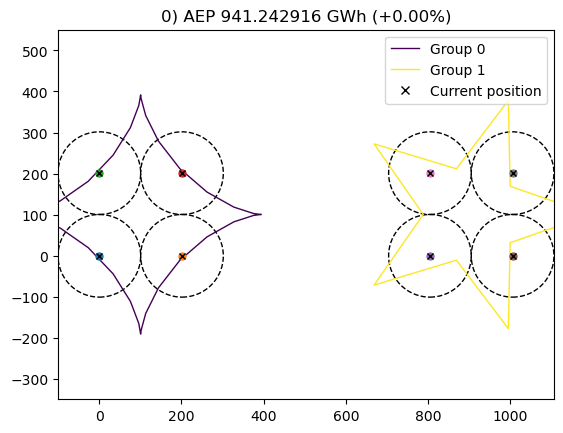

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


Iteration limit reached    (Exit mode 9)
            Current function value: -947.2656701277318
            Iterations: 30
            Function evaluations: 35
            Gradient evaluations: 30
Optimization FAILED.
Iteration limit reached
-----------------------------------
Optimized in	5.774s


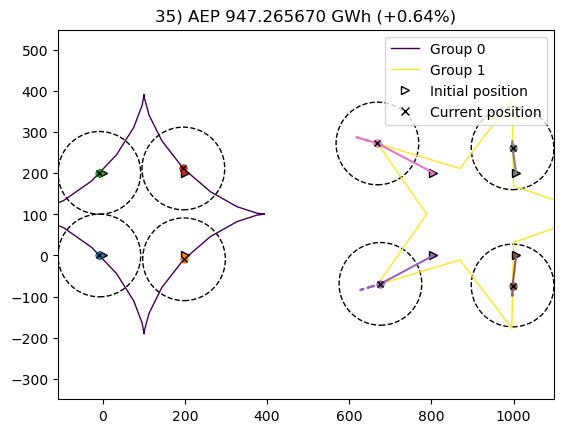

In [ ]:
wind_turbines = GenericWindTurbine("GenWT", 100.6, 2000, 150)
site = LillgrundSite()
wf_model = Bastankhah_PorteAgel_2014(site, wind_turbines, k=0.0324555)


def _get_astroid_points(cx: float, cy: float, radius: float, num_points: int = 32):
    t = np.linspace(0, 2 * np.pi, num_points)
    x = cx + radius * np.cos(t) ** 3
    y = cy + radius * np.sin(t) ** 3
    return np.column_stack((x, y))


def _get_star_points(cx: float, cy: float, radius: float, points: int = 5):
    angles = np.linspace(0, 2 * np.pi, 2 * points, endpoint=False)
    outer_pts = np.array(
        [[cx + radius * np.cos(t), cy + radius * np.sin(t)] for t in angles[::2]]
    )
    inner_pts = np.array(
        [
            [cx + (radius * 0.4) * np.cos(t), cy + (radius * 0.4) * np.sin(t)]
            for t in angles[1::2]
        ]
    )
    points = np.empty((2 * points, 2))
    points[::2] = outer_pts
    points[1::2] = inner_pts
    return points


def _get_corners(x: np.ndarray, y: np.ndarray, radius, shape="astroid"):
    """Get corner points for different shapes."""
    cx = x.mean()
    cy = y.mean()

    if shape == "astroid":
        return _get_astroid_points(cx, cy, radius)
    elif shape == "star":
        return _get_star_points(cx, cy, radius)
    else:
        raise ValueError(f"Unknown shape: {shape}")


grid_side = 2
wt_x, wt_y = np.meshgrid(
    np.linspace(0, wind_turbines.diameter() * grid_side, grid_side),
    np.linspace(0, wind_turbines.diameter() * grid_side, grid_side),
)
wt_x, wt_y = wt_x.flatten(), wt_y.flatten()
radius = np.sqrt((wt_x - wt_x.mean()) ** 2 + (wt_y - wt_y.mean()) ** 2).max() + 150

wt_x2 = wt_x + wind_turbines.diameter() * grid_side * 4.0
wt_y2 = wt_y
X_full = np.concatenate([wt_x, wt_x2])
Y_full = np.concatenate([wt_y, wt_y2])
n_wt = len(X_full)

constraint_comp = MultiWFBoundaryConstraint(
    geometry=[
        _get_corners(wt_x, wt_y, radius, shape="astroid"),
        _get_corners(wt_x2, wt_y2, radius, shape="star"),
    ],
    wt_groups=[np.arange(n_wt // 2), np.arange(n_wt // 2, n_wt)],
    boundtype=BoundaryType.POLYGON,
)
cost_comp = PyWakeAEPCostModelComponent(
    windFarmModel=wf_model, n_wt=n_wt, grad_method=autograd
)

def callback(ax):
    ax.set_xlim(-200, 1200)
    
problem = TopFarmProblem(
    design_vars={"x": X_full, "y": Y_full},
    n_wt=n_wt,
    constraints=(
        [
            constraint_comp,
            SpacingConstraint(min_spacing=wind_turbines.diameter() * 2),
        ]
    ),
    cost_comp=cost_comp,
    driver=(EasyScipyOptimizeDriver(optimizer="SLSQP", maxiter=30)),
plot_comp=XYPlotComp(),
)

_, state, recorder = problem.optimize(disp=True)

### Exercises

1. Run non-convex optimization case with the SGD driver instead of SLSQP
2. Try to tune the optimizer to beat the improvement achieved above (note that SGD improvement must be measured on full range of WS/WD i.e. not sampled subset; inspect what parameter `full` does in the AEP (objective) function of SGD iterations)